# Model evaluation
In some cases, we may not know the number of segments or we may wish to compare a power law against other types of rating models.
For these cases, we can use information criteria to select the best model.

In [1]:
# load tutorial data
from ratingcurve import data
%load_ext autoreload
%autoreload 2
%xmode minimal
#suppress warnings and errors


import pymc as pm
import arviz as az
from ratingcurve.ratingmodel import PowerLawRating

from ratingcurve import data

df = data.load('green channel')

Exception reporting mode: Minimal


Fit the data to ratings with 1 to 4 segments and determine which is best.

In [2]:
%%capture
# OUtput supressed, this will print "Finished" after running each of the four models

segments = [1, 2, 3, 4]
traces = []
for segment in segments:
    powerrating = PowerLawRating(q=df['q'],
                             h=df['stage'], 
                             q_sigma=df['q_sigma'],
                             segments=segment,
                             prior={'distribution':'uniform'})
    with powerrating:
            mean_field = pm.fit(method='advi', n=150_000)
            trace = mean_field.sample(5000)
            traces.append(pm.compute_log_likelihood(trace)) # Add arg to compute log likelihood

Finished [100%]: Average Loss = -38.11
Finished [100%]: Average Loss = -49.333
Finished [100%]: Average Loss = -44.883
Finished [100%]: Average Loss = -28.19


now use `arviz.compare` to format the output

In [3]:
# this model will generate warnings about the WAIC
import warnings; warnings.filterwarnings('ignore')

compare_dict = {f'{i} segment': traces[i-1] for i in segments}
az.compare(compare_dict, ic='waic')

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
2 segment,0,72.105324,6.656599,0.000000,1.000000e+00,3.598680,0.000000,True,log
3 segment,1,56.674576,21.272083,15.430748,0.000000e+00,6.694918,5.261154,True,log
1 segment,2,53.496233,4.434619,18.609091,0.000000e+00,3.277646,4.865267,True,log
4 segment,3,39.667206,16.799477,32.438117,8.739676e-13,8.918132,9.743546,True,log


As we expected, the 2-segment model was ranked highest.

# Residuals
In practice, it can be helpful to plot to rating error
(the deviations between the rating fit and the discharge observations).
Here is a demonstration of how.

In [4]:
import matplotlib.pyplot as plt

segments = 2
powerrating = PowerLawRating(q=df['q'],
                             h=df['stage'], 
                             q_sigma=df['q_sigma'],
                             segments=segments,
                             prior={'distribution':'uniform'})

In [5]:
with powerrating:
    mean_field = pm.fit(method='advi', n=150_000)
    trace = mean_field.sample(5000)

Finished [100%]: Average Loss = -49.609


Text(0, 0.5, '')

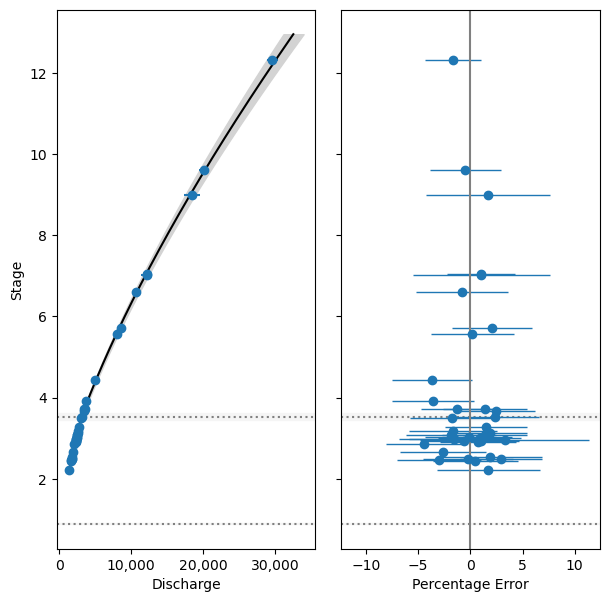

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(7,7), sharey=True)

powerrating.plot(trace, ax[0])
powerrating.plot_residuals(trace, ax[1])


plt.subplots_adjust(wspace=0.1)
ax[1].set_ylabel('')